# Introduction

This Jupyter Notebook is a continuation of a series of notebooks in a project assessing the predictive role of chronic health conditions in the occurrence of long COVID symptoms. For ease in understanding the contents of this notebook, please first refer to the codebook folder and the 'cleaning_and_eda' notebook (located in the Psych_755_final GitHub repository).

This notebook seeks to run the cleaned datset through a series of random forest models, and explore the differences in performance between the performances of said models. The dataset is read in, briefly explored, then run through a random forest model with all predictors. Following this, a feature importance is conducted & a feature importance plot is created. This process is repeated with two more models. One removes the most important feature from the feature importance in the firest random forest model. The final random forest model also removes demographic variables, exploring exclusively the role of chronic health conditions in the occurrence of long COVID symptoms. The accuracies of the three models are compared and final predictions are made with a held-out test set. Test predictions can be found in the Psych_755_final GitHub repository.

In [18]:
# import necessary packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

sns.set_context('paper')

Above, we load in the necessary python libraries for this notebook. Below we read in the test dataset that has already been cleaned and had EDA performed. A sample is printed to confirm the dataset was read in properly. The dataset was cleaned so that all nominal variables would be collapsed into binary variables. Random forest models do not natively handle multi-class nominal variables, leading to this decisiion. All variables are confirmed to be binary. 

In [7]:
# read in data & sample data
df = pd.read_csv('data_train.csv', dtype={21: str})

df.sample(3).transpose()

,25804,55019,51697
heart_attack,0,0,0
coronary_heart_disease,0,0,0
stroke,0,0,0
asthma,0,0,0
skin_cancer,0,0,0
melanoma_or_other,0,0,0
copd,0,0,0
depression,0.0,0.0,0.0
kidney_disease,0,0,0
arthiritis,1,1,0


Data types are checked to make sure all variables were read in as numeric. 

In [9]:
# checking data types
# everything is numeric
df.dtypes

heart_attack                     int64
coronary_heart_disease           int64
stroke                           int64
asthma                           int64
skin_cancer                      int64
melanoma_or_other                int64
copd                             int64
depression                     float64
kidney_disease                   int64
arthiritis                       int64
veteran_status                   int64
children                         int64
pregnant                       float64
deaf                             int64
covid_vacc_status              float64
prolonged_covid_symptoms         int64
diabetic                         int64
college_or_more                  int64
income_over_50k                float64
currently_employed               int64
is_married                       int64
owns_home                       object
covid_pos                        int64
had_limiting_covid_symptoms    float64
two_or_more_vaccs              float64
dtype: object

Basic decriptive statistics are obtained of the training dataset. The column 'children' has a really high maximum value (23 children), which should bre explored. Most of the population seems to be free of chronic health conditions. This dataset contains only individuals who have tested positive for COVID-19, as the minimum and maximum are 1. 93% of the sample has received two ore more COVID-19 vaccinations and about 95% of the sample experienced limting COVID symptoms.

In [14]:
# basic descriptive statistics
# confirm that all variables are binary
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
heart_attack,72297.0,0.044580,0.206381,0.0,0.0,0.0,0.0,1.0
coronary_heart_disease,72297.0,0.051178,0.220362,0.0,0.0,0.0,0.0,1.0
stroke,72297.0,0.033224,0.179222,0.0,0.0,0.0,0.0,1.0
asthma,72297.0,0.172469,0.377790,0.0,0.0,0.0,0.0,1.0
skin_cancer,72297.0,0.067776,0.251363,0.0,0.0,0.0,0.0,1.0
melanoma_or_other,72297.0,0.093807,0.291563,0.0,0.0,0.0,0.0,1.0
copd,72297.0,0.068495,0.252596,0.0,0.0,0.0,0.0,1.0
depression,72296.0,0.237689,0.425671,0.0,0.0,0.0,0.0,1.0
kidney_disease,72297.0,0.041302,0.198989,0.0,0.0,0.0,0.0,1.0
arthiritis,72297.0,0.313111,0.463762,0.0,0.0,0.0,1.0,1.0


Below we have explored the 'children' column, looking at the number of people who have more than 10 children. There are two clear outliers (21 & 23 children). However, since the dataset is so large, this may not be serious cause for concern. 

In [24]:
# number of people who have more than 10 children
df[df['children'] > 10]['children'].value_counts()

children
12    3
11    2
14    2
21    1
23    1
17    1
Name: count, dtype: int64

The shape of the dataset is checked, showing 72,297 observations of 25 variables. 

In [9]:
# check number of observation & number of features
df.shape

(72297, 25)

The outcome variable 'prolonged_covid_symptoms' is checked for missingness, since a random forest model is not capable of handling a dataset with missing values in the outcome variable. Luckily, this dataset has been cleaned and missing responses have been removed. This is confirmed below.

In [1]:
# check outcome for missingness
print(df['prolonged_covid_symptoms'].isna().sum())

NameError: name 'df' is not defined

# Random Forest Model Containing all Predictors

Below the first random forest model is set up using all features in the dataset. The 'children' column is scaled to improve performance. A train-test split is instatiated, the model is run and performance metrics are obtained. 

In [ ]:
# establish X and y
X = df.drop(columns=['prolonged_covid_symptoms'])
y = df['prolonged_covid_symptoms']

# scale numeric column
scaler = StandardScaler()
if 'children' in X.columns:
    X['children'] = scaler.fit_transform(X[['children']])

In [22]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

# fit rf model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

Accuracy: 0.9994132193302318

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     18795
           1       1.00      1.00      1.00      5064

    accuracy                           1.00     23859
   macro avg       1.00      1.00      1.00     23859
weighted avg       1.00      1.00      1.00     23859


Confusion Matrix:
 [[18793     2]
 [   12  5052]]


In [ ]:
# run prediction
preds = rf.predict(X_test)

# performance metrics
print("Accuracy:", accuracy_score(y_test, preds))
print("\nClassification Report:\n", classification_report(y_test, preds))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, preds))

This model has an extremely high accuracy, which is very strange. Perhaps the feature importance will tell us more. Below we are checking the class balances of the outcome variable, y.

In [24]:
# checking class balances in y
print(y.value_counts(normalize=True))

prolonged_covid_symptoms
0    0.785856
1    0.214144
Name: proportion, dtype: float64


## Feature Importance for rf

Feature importances are obtained, showing that 'had_limiting_covid_symptoms' had a highly influential role in the occurrence of long COVID symptoms. This makes sense conceptually, but not to a point of 99.9% accuracy. This model seems overfit.

In [31]:
# feature importance for rf
viz_fi = pd.DataFrame({'Features': X_train.columns, 'Importance':
                         rf.feature_importances_})
viz_fi.style.hide()

Features,Importance
heart_attack,0.002362
coronary_heart_disease,0.002386
stroke,0.002128
asthma,0.005741
skin_cancer,0.002320
melanoma_or_other,0.003233
copd,0.004777
depression,0.008298
kidney_disease,0.002421
arthiritis,0.005258


The bar plot below confirms the ridiculously overpowering role that 'had_limitng_covid_symptoms' has in this model, maybe further indicating that this model is overfit.

<Axes: xlabel='Importance', ylabel='Features'>

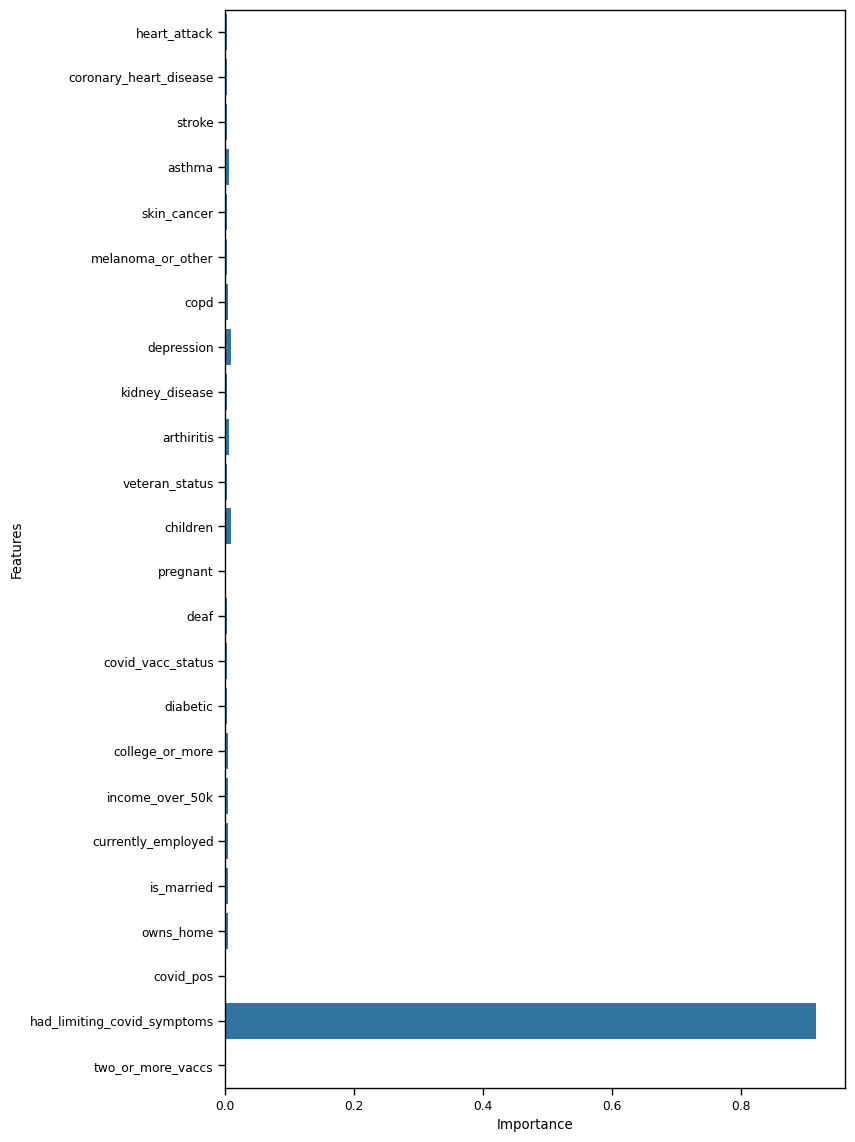

In [33]:
# feature importance bar plot for rf
fig, ax = plt.subplots(figsize=(8, 14))
sns.barplot(viz_fi, x = 'Importance', y = 'Features', ax=ax)

# Random Forest Model Excluding 'primary_covid_symptom'

Below another random forest model is run, this time excluding the most important feature, 'had_limiting_covid_symptoms'. This model has 77% accuracy, which seems more reliable than the previous 99.9%.

In [28]:
# establish X & y, dropping 'had_limiting_covid_symptoms'
X_2 = df.drop(columns=['prolonged_covid_symptoms', 'had_limiting_covid_symptoms'])
y_2 = df['prolonged_covid_symptoms']

# scale numeric column
scaler = StandardScaler()
X_2['children'] = scaler.fit_transform(X_2[['children']])

In [30]:
# train-test split
X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(
X_2, y_2, test_size=0.33, random_state=42
)

# fit rf_2 model
rf_2 = RandomForestClassifier(random_state=42)
rf_2.fit(X_2_train, y_2_train)

RandomForestClassifier(random_state=42)

In [31]:
# run prediction
preds = rf_2.predict(X_2_test)

# performance metrics
print("Accuracy:", accuracy_score(y_2_test, preds))
print("\nClassification Report:\n", classification_report(y_2_test, preds))
print("\nConfusion Matrix:\n", confusion_matrix(y_2_test, preds))

Accuracy: 0.7685150257764366

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.95      0.87     18795
           1       0.34      0.09      0.15      5064

    accuracy                           0.77     23859
   macro avg       0.57      0.52      0.51     23859
weighted avg       0.70      0.77      0.71     23859


Confusion Matrix:
 [[17855   940]
 [ 4583   481]]


## Feature Importance for rf_2

Upon looking at the feature importances for this second random forest model it appears that 'children' is now the most important feature. Beyond that, it seems that a lot of the demographic variables have greater predictive value than the chorinc health condition columns. This is a very interesting finding that would be worth exploring further, as socioeconomic impacts of this pandemic have been of great interest. 

In [40]:
# feature importance for rf_2
viz_fi_2 = pd.DataFrame({'Features': X_2_train.columns, 'Importance':
                         rf_2.feature_importances_})
viz_fi_2.style.hide()

Features,Importance
heart_attack,0.026398
coronary_heart_disease,0.027579
stroke,0.025833
asthma,0.036787
skin_cancer,0.035112
melanoma_or_other,0.046419
copd,0.033727
depression,0.043841
kidney_disease,0.030535
arthiritis,0.041218


<Axes: xlabel='Importance', ylabel='Features'>

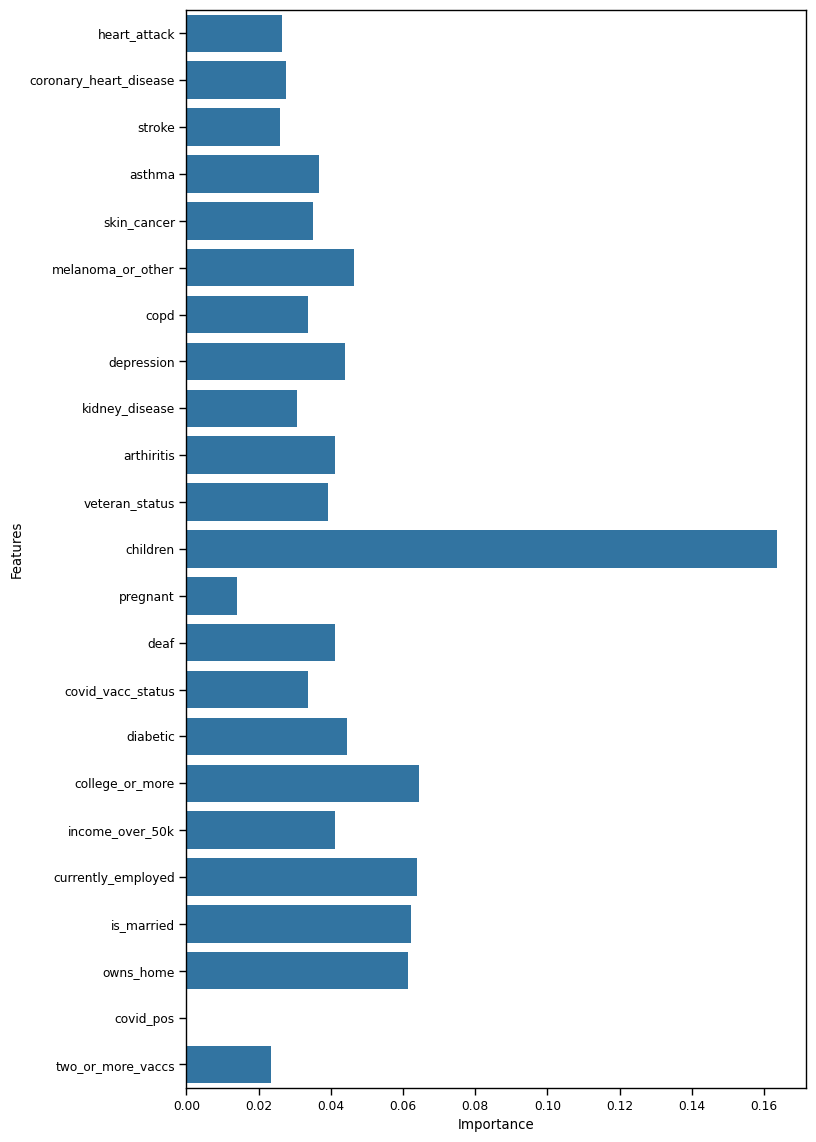

In [41]:
# feature importance bar plot for rf_2
fig, ax = plt.subplots(figsize=(8, 14))
sns.barplot(viz_fi_2, x = 'Importance', y = 'Features', ax=ax)

# Random Forest Model Excluding 'primary_covid_symptom' & demographic variables

Below a third random forest model is created to further isolate the predictive value of chronic health conditions in the occurrence of long COVID symptoms. Demographic variables are grouped together and dropped from teh dataset, along with 'had_limiting_covid_symptoms'. This model performs with about 65% accuracy, which indicates that chronic health conditions may not be very predictive of long COVID symptoms. The feature importances for this model reveal some interesting results, showing that of the chronic health conditions explored in this study depression has the highest predictive values in the occurrence of long COIVD symptoms. 

In [34]:
# group together demographic variables to prepare for dropping
demo_vars = ['is_married', 'college_or_more', 'owns_home', 'veteran_status',
             'currently_employed', 'children', 'income_over_50k', 'pregnant', 'deaf']

# establish X & y, dropping 'had_limting_covid_symptoms' & demo vars
X_3 = df.drop(columns=['prolonged_covid_symptoms', 'had_limiting_covid_symptoms'] + demo_vars)
y_3 = df['prolonged_covid_symptoms']

In [36]:
# train-test split
X_3_train, X_3_test, y_3_train, y_3_test = train_test_split(
    X_3, y_3, test_size=0.33, random_state=42)

# fit rf_3 model
rf_3 = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_3.fit(X_3_train, y_3_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [38]:
# run prediction
preds = rf_3.predict(X_3_test)

# performance metrics
print("Accuracy:", accuracy_score(y_3_test, preds))
print("\nClassification Report:\n", classification_report(y_3_test, preds))
print("\nConfusion Matrix:\n", confusion_matrix(y_3_test, preds))

Accuracy: 0.6480154239490339

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.71      0.76     18795
           1       0.28      0.43      0.34      5064

    accuracy                           0.65     23859
   macro avg       0.55      0.57      0.55     23859
weighted avg       0.71      0.65      0.67     23859


Confusion Matrix:
 [[13268  5527]
 [ 2871  2193]]


## Feature Importance for rf_3

In [48]:
# feature importance for rf_3
viz_fi_3 = pd.DataFrame({'Features': X_3_train.columns, 'Importance':
                         rf_3.feature_importances_})
viz_fi_3.style.hide()

Features,Importance
heart_attack,0.053187
coronary_heart_disease,0.059658
stroke,0.050881
asthma,0.117272
skin_cancer,0.059961
melanoma_or_other,0.066043
copd,0.091084
depression,0.184135
kidney_disease,0.056640
arthiritis,0.111152


<Axes: xlabel='Importance', ylabel='Features'>

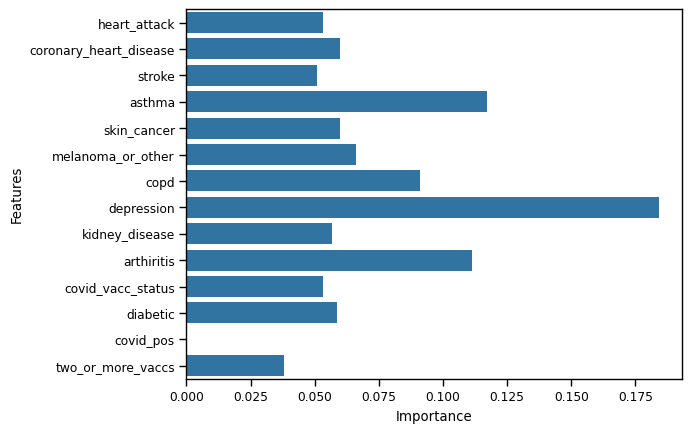

In [49]:
# feature importance bar plot for rf_3
sns.barplot(viz_fi_3, x = 'Importance', y = 'Features')

# Test Predictions

Below a held-out test dataset is read in and sampled to check that it was read in correctly. The size is checked, showing the same number of variables as the test set (25), and about 1/3 of the observations as the training set (24,100). The column names are checked, showing they are the same as the training set. It is necessary for these column names to be identical in order for the predictions to run.

In [40]:
# read in & sample test data
test_df = pd.read_csv('data_test.csv')

test_df.sample(3)

,heart_attack,coronary_heart_disease,stroke,asthma,skin_cancer,melanoma_or_other,copd,depression,kidney_disease,arthiritis,...,prolonged_covid_symptoms,diabetic,college_or_more,income_over_50k,currently_employed,is_married,owns_home,covid_pos,had_limiting_covid_symptoms,two_or_more_vaccs
17979,0,0,0,0,0,0.0,0,0,0,0,...,1,0,1,1,1,1,1,1,1.0,0.0
19344,0,0,0,0,0,0.0,0,0,0,0,...,0,0,1,1,0,1,0,1,NaN,1.0
1810,0,0,0,0,0,0.0,0,0,0,1,...,1,0,0,0,0,0,1,1,1.0,NaN


In [55]:
# assess size of dataset
test_df.shape

(24100, 25)

In [57]:
# identical columns as training set
test_df.columns

Index(['heart_attack', 'coronary_heart_disease', 'stroke', 'asthma',
       'skin_cancer', 'melanoma_or_other', 'copd', 'depression',
       'kidney_disease', 'arthiritis', 'veteran_status', 'children',
       'pregnant', 'deaf', 'covid_vacc_status', 'prolonged_covid_symptoms',
       'diabetic', 'college_or_more', 'income_over_50k', 'currently_employed',
       'is_married', 'owns_home', 'covid_pos', 'had_limiting_covid_symptoms',
       'two_or_more_vaccs'],
      dtype='object')

Test predictions are generated performance metircs are obtained. This model has a 76% accuracy in the held-out dataset, indicating this model is not overfit. The predictions are added in a new column to the original dataset and saved as a new .csv file.

In [69]:
# Define X and y for testing
X_test = test_df.drop(columns=['prolonged_covid_symptoms', 'had_limiting_covid_symptoms'])
y_test = test_df['prolonged_covid_symptoms']

# Make predictions
y_pred = rf_2.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.7581327800829876
              precision    recall  f1-score   support

           0       0.79      0.93      0.86     18939
           1       0.32      0.11      0.17      5161

    accuracy                           0.76     24100
   macro avg       0.56      0.52      0.51     24100
weighted avg       0.69      0.76      0.71     24100



In [71]:
# add predictions to dataset
test_df['predicted_prolonged_covid_symptoms'] = y_pred

# save as .csv
test_df.to_csv("test_predictions.csv", index=False)

# confirm file has saved
print("Predictions saved to test_predictions.csv")

Predictions saved to test_predictions.csv


# Conclusion

In this study, a random forest classification model was developed to predict the likelihood of prolonged COVID-19 symptoms based on a set of binary predictors. When evaluated on the independent test set, the model achieved an accuracy of 76%, indicating that it was able to correctly classify the outcome in over 3/4 of cases. This level of performance suggests that the selected predictors contain meaningful information related to prolonged COVID-19 outcomes, although there remains room for improvement. Future work could focus, incorporating additional predictive features, optimzing model parameters, and exploring alternative algorithms to enhance predictive performance and better support clinical or public health decision-making.